In [1]:
from collections import Counter
import numpy as np
from visualize_events.snomed import *
from visualize_events.data import *

T = load_dag()
print(T.edge_types)
T = T.get_edge_types([0,1])
print(len(T))

C:\Users\Sean McCarren\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Sean McCarren\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Sean McCarren\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


0                                    Is a (attribute)
1                            Finding site (attribute)
2                   Associated morphology (attribute)
3                                  Method (attribute)
4                              Interprets (attribute)
                           ...                       
95                               Severity (attribute)
96    Has ingredient qualitative strength (attribute)
97                    Has surface texture (attribute)
98                    Relative to part of (attribute)
99                                 Before (attribute)
Length: 100, dtype: object
356172


In [2]:
preds = get_predictions(861, predictor='frequency') # frequency, ci_low, ci_upp
P = T.set_predictions(preds)
print(len(P))

7 predictions not found


1747


In [3]:
C = P.compact_preds()
C.set_predictions(preds)
C

7 predictions not found


In [4]:
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace

def layout(node):
    if hasattr(node, 'f'):
        frequency = float(node.f)
        lowerbound = float(node.lb)
        
        C = CircleFace(radius=frequency * 100, color="Red", style="sphere")
        C.opacity=lowerbound
        faces.add_face_to_node(C, node, 0, position="float")

    faces.add_face_to_node(AttrFace("name"), node, column=0)

# Create an empty TreeStyle
ts = TreeStyle()

# Set our custom layout function
ts.layout_fn = layout

# Draw a tree
ts.mode = "c"

# We will add node names manually
ts.show_leaf_name = True
# Show branch data
ts.show_branch_length = False
ts.show_branch_support = False


# Getting the tree
threshold = 0.03
G = C.copy(init=False)
G = G.set_predictions(preds)
print(len(G))
G = G.filter(keep_constraint = lambda n: n.pred_agg >= threshold)
print(len(G))
G.splice(keep_constraint = lambda n : len(n.children) != 1)
print(len(G))
# G.make_tree()
G.attr_label()
t = G.get_newick()
t = Tree(t, format=8, quoted_node_names=True)

# t.show(tree_style=ts)
t.render("mytree.png", w=183, units="mm", dpi=1000, tree_style=ts)
print("Done")

7 predictions not found


775
86
40
Done


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import pydot
import networkx as nx
import numpy as np
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.manifold import TSNE

In [6]:
# g = nx.DiGraph()

# edges = [
#     (node.name, child.name) for node in P.nodes.values() for child in node.children
# ]
# g.add_edges_from(edges)
# nx.draw(g)

In [7]:
tree = C.copy(init=False)
print(len(tree))
# tree.splice(keep_constraint = lambda n: n.pred_agg >= 0.01)
tree.add_parent_store()
tree = tree.compact_preds()
# tree = tree.set_predictions(preds)
print(len(tree))
tree.add_parent_store()
tree.attr_label()
edges = [
    (node.name, child.name) for node in tree.nodes.values() for child in node.children
]
g = nx.DiGraph()
g.add_edges_from(edges)
nodes = list(tree.nodes.values())
#draw_nodes = [n for n in nodes if n.pred_agg > 0.01]
draw_nodes = nodes

N = len(nodes)
anc_store = [set(anc for anc in n.ancestors()) for n in nodes]
dist = np.zeros((N, N))
for i, anc1 in enumerate(anc_store):
    for j, anc2 in enumerate(anc_store[i+1:], i+1):
#         common = anc1.intersection(anc2)
        diff = anc1.symmetric_difference(anc2)
        #d = 1/len(common)
#         d = 1/(sum(a.depth for a in common)+1)
        d = len(diff)
        dist[i, j] = d
        dist[j, i] = d

tsne = TSNE(metric="precomputed",
            perplexity=30,
            early_exaggeration=10)
embedding = tsne.fit_transform(dist)
pos = {n.name: tuple(embedding[i]) for i, n in enumerate(nodes) if n in draw_nodes}

fig = plt.figure(figsize=(15,15))
ax = fig.gca()

def node_size(node):
    s = 1
    if node.pred_agg is not None:
        s += node.pred_agg * 50
    if node.pred is not None:
        s += node.pred * 200
    return s

def node_color(node):
    if node.pred is not None:
        return "red"
    else:
        return "blue"

nx.draw_networkx(g,
        pos=pos,
        nodelist=[n.name for n in draw_nodes],
#         edgelist=[],
        node_size=[node_size(n) for n in draw_nodes],
        node_color=[node_color(n) for n in draw_nodes],
        labels={n.name: (n.label if n.pred is not None and n.pred > 0.03 else "") for n in draw_nodes},
        width=0.2,
        ax=ax)

No sources! was the tree a single and did you discard it?


775
1


C:\Users\Sean McCarren\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Sean McCarren\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Sean McCarren\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


ValueError: Found array with 1 sample(s) (shape=(1, 1)) while a minimum of 2 is required.

In [ ]:
print([
    nx.is_tree(G),
    nx.is_forest(G),
    nx.is_arborescence(G),
    nx.is_branching(G),
])

In [ ]:
T.root.children

In [ ]:
[str(c) for c in T.root.children[0].children]

In [8]:
# Choosing two nodes
C.add_parent_store()

Is = []
for I in [0,2]:
    i = 0
    for k in C.nodes:
        n = C.nodes[k]
        if len(n.children) == 0:
            print(n)
            if i == I:
                x = n
                break
            i += 1
    Is.append(x)

4224004
4224004
422400008
73173006


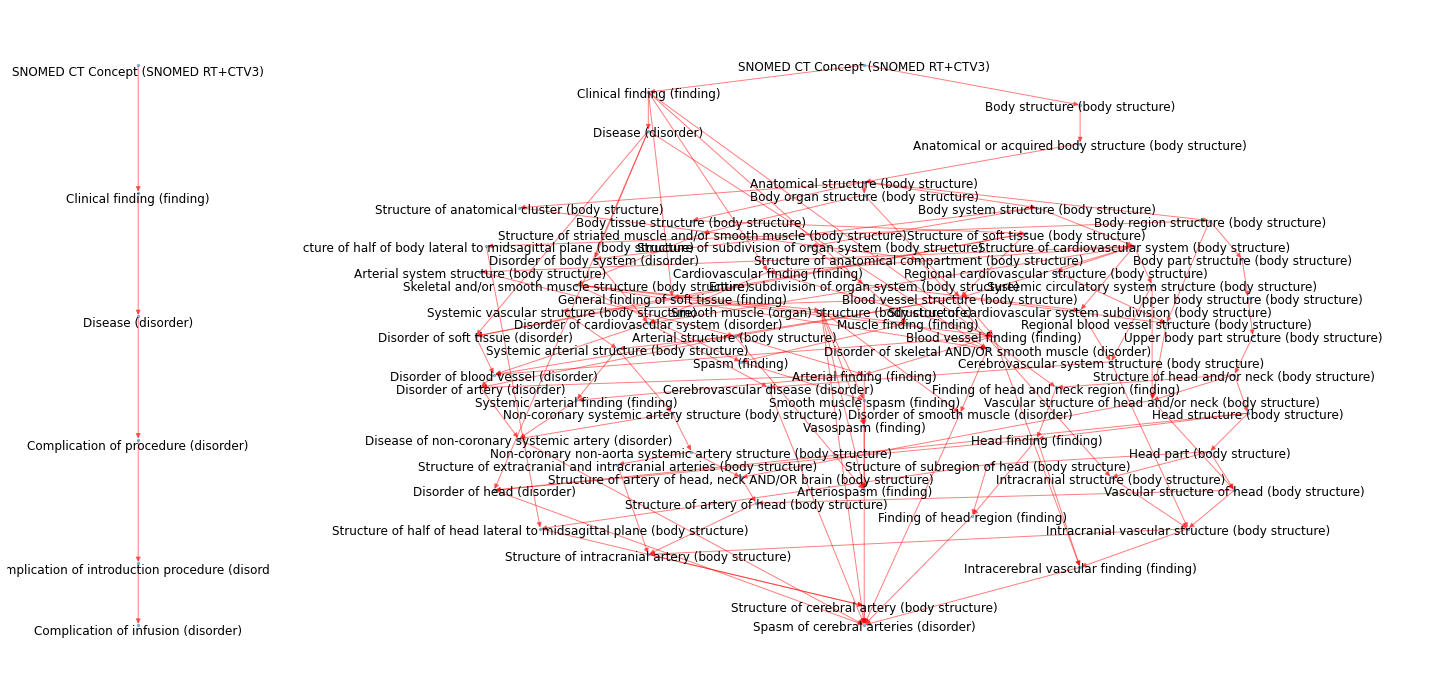

In [9]:
# two different trees
T.attr_label()

fig, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [0.7, 3]})

plt.xlim([-1.3, 1.3])
draw_subgraph_to_leaf(T.nodes[Is[0].name], T, ax=axs[0])
plt.tight_layout()
# plt.savefig(f"example_{Is[0]}.pdf", dpi=600)

# plt.figure(figsize=(9,7))
# plt.xlim([-1.3, 1.3])
draw_subgraph_to_leaf(T.nodes[Is[1].name], T, ax=axs[1])
# plt.tight_layout()
plt.savefig(f"examples.pdf", dpi=600)

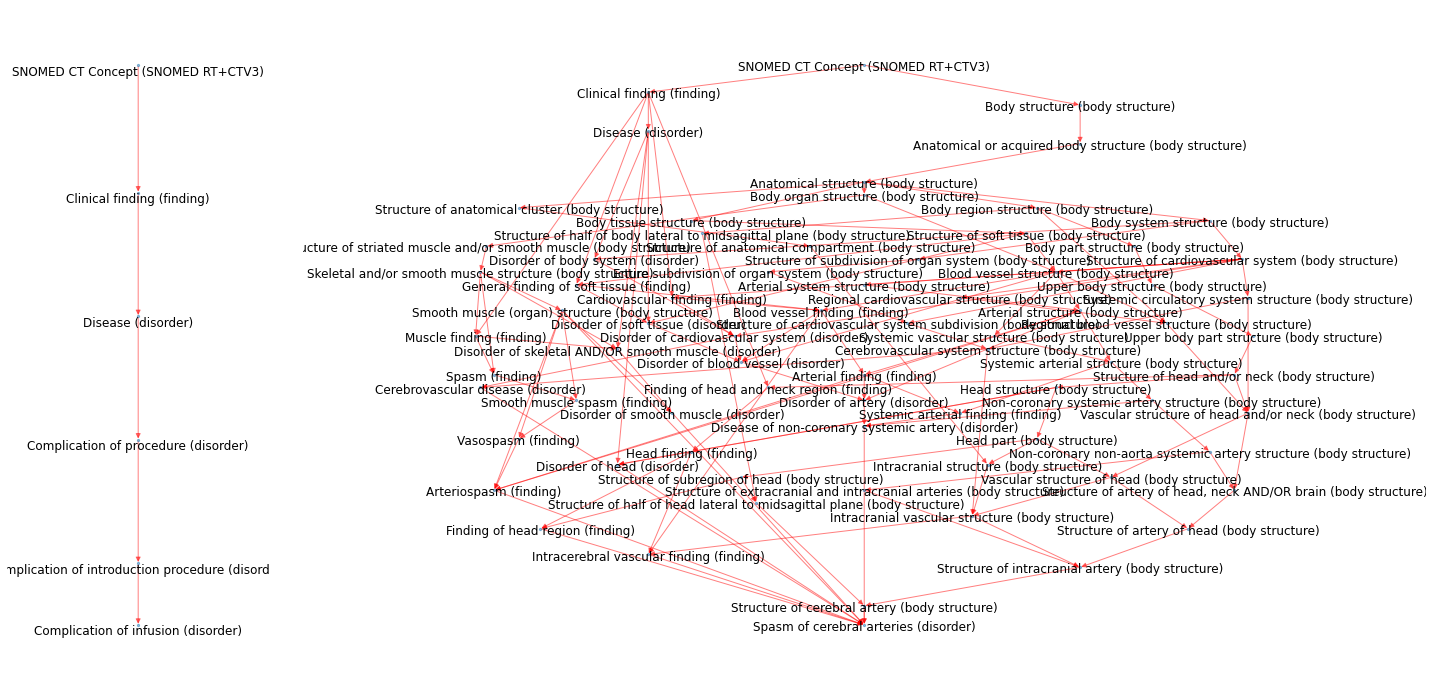

In [10]:
# two different trees
P.add_parent_store()
P.attr_label()

fig, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [0.7, 3]})

plt.xlim([-1.3, 1.3])
draw_subgraph_to_leaf(P.nodes[Is[0].name], T, ax=axs[0])
plt.tight_layout()
# plt.savefig(f"example_{Is[0]}.pdf", dpi=600)

# plt.figure(figsize=(9,7))
# plt.xlim([-1.3, 1.3])
draw_subgraph_to_leaf(P.nodes[Is[1].name], T, ax=axs[1])
# plt.tight_layout()
plt.savefig(f"examples.pdf", dpi=600)

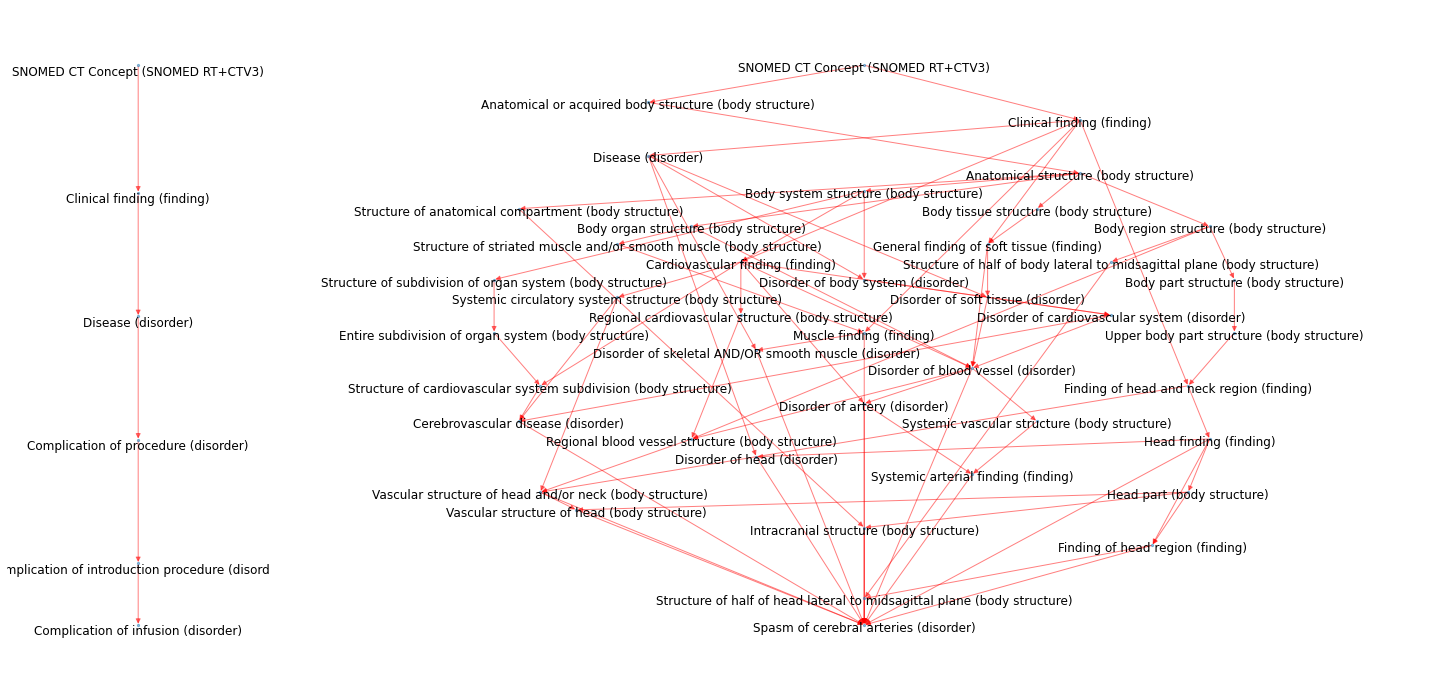

In [11]:
# two different trees
C.add_parent_store()
C.attr_label()

fig, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [0.7, 3]})

plt.xlim([-1.3, 1.3])
draw_subgraph_to_leaf(C.nodes[Is[0].name], T, ax=axs[0])
plt.tight_layout()
# plt.savefig(f"example_{Is[0]}.pdf", dpi=600)

# plt.figure(figsize=(9,7))
# plt.xlim([-1.3, 1.3])
draw_subgraph_to_leaf(C.nodes[Is[1].name], T, ax=axs[1])
# plt.tight_layout()
plt.savefig(f"examples.pdf", dpi=600)

In [12]:
T.root.children

[P:1, C:10 NODE: Social context (social concept),
 P:1, C:65 NODE: Qualifier value (qualifier value),
 P:1, C:5 NODE: Organism (organism),
 P:1, C:2 NODE: Environment or geographical location (environment / location),
 P:1, C:10 NODE: Situation with explicit context (situation),
 P:1, C:5 NODE: SNOMED CT Model Component (metadata),
 P:1, C:8 NODE: Staging and scales (staging scale),
 P:1, C:69 NODE: Specimen (specimen),
 P:1, C:11 NODE: Physical object (physical object),
 P:1, C:6 NODE: Record artifact (record artifact),
 P:1, C:1 NODE: Special concept (special concept),
 P:1, C:8 NODE: Body structure (body structure),
 P:1, C:21 NODE: Physical force (physical force),
 P:1, C:37 NODE: Procedure (procedure),
 P:1, C:115 NODE: Clinical finding (finding),
 P:1, C:19 NODE: Pharmaceutical / biologic product (product),
 P:1, C:12 NODE: Substance (substance),
 P:1, C:39 NODE: Observable entity (observable entity),
 P:1, C:31 NODE: Event (event)]